## Predicting Price of House base on size

For this project, we want to build a model for House in Buenos Aires proper ("Capital Federal") that cost less than $350,000. 

In [1]:
# import necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Extraction


In [2]:
# check the number of files in the zip folder
file_path = r"C:\Users\ncc\Downloads\archive (2).zip"
with ZipFile(file_path, "r") as f:
    f.printdir()

File Name                                             Modified             Size
buenos-aires-real-estate-1.csv                 2024-02-10 05:32:04      2098075
buenos-aires-real-estate-2.csv                 2024-02-10 05:32:04      2087786


In [3]:
# extract th needed dataset
with ZipFile(file_path) as f:
    print("Etracting the all dataset")
    f.extractall()
    print("Extracting done...")

Etracting the all dataset
Extracting done...


## Data Cleaning


In [26]:
# creating function that allows loading and cleaning of dataset
def wrangle(path):
    # read csv file in to a dataframe
    df = pd.read_csv(path)

    # Subset to properties in capital federal
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    # Subset to "apartment"
    mask_hse = df["property_type"] == "apartment"
    # subset to properties where price_aprox_usd < 400_000
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_hse & mask_price]
    # remove outliers by "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)

    df = df[mask_area]
    
    return df

In [27]:
# load dataset and inspect
df = wrangle("buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2068 entries, 0 to 8604
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2068 non-null   object 
 1   property_type               2068 non-null   object 
 2   place_with_parent_names     2068 non-null   object 
 3   lat-lon                     1984 non-null   object 
 4   price                       1944 non-null   float64
 5   currency                    1944 non-null   object 
 6   price_aprox_local_currency  1944 non-null   float64
 7   price_aprox_usd             1944 non-null   float64
 8   surface_total_in_m2         1430 non-null   float64
 9   surface_covered_in_m2       1859 non-null   float64
 10  price_usd_per_m2            1314 non-null   float64
 11  price_per_m2                1752 non-null   float64
 12  floor                       533 non-null    float64
 13  rooms                       1580 non-n

In [9]:
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
18,sell,apartment,|Argentina|Capital Federal|Belgrano|,"-34.5646269,-58.4412741",600000.0,USD,9097440.0,600000.0,220.0,NaN,2727.272727,NaN,NaN,5.0,NaN,http://belgrano.properati.com.ar/jvge_venta_de...


## Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Apartment Sizes')

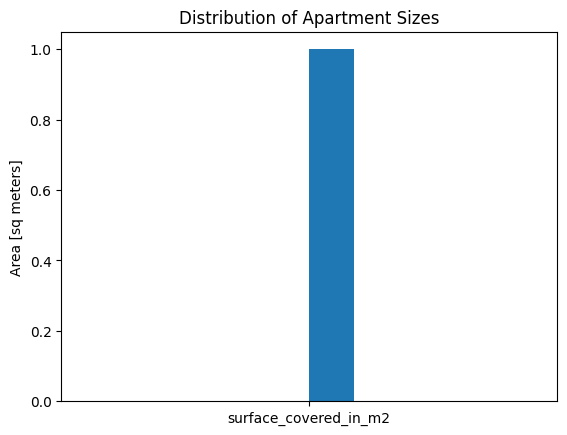

In [20]:
plt.hist("surface_covered_in_m2")
plt.ylabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes")

In [ ]:
# checking for outlies base on the histogram
df.describe()["surface_covered_in_m2"]

count     1635.000000
mean        97.877064
std       1533.057610
min          0.000000
25%         38.000000
50%         50.000000
75%         73.000000
max      62034.000000
Name: surface_covered_in_m2, dtype: float64

In [25]:
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area =df["surface_covered_in_m2"].between(low, high)
mask_area. head

<bound method NDFrame.head of 0       False
4        True
9        True
11      False
20      False
        ...  
8589     True
8590     True
8593     True
8601     True
8604     True
Name: surface_covered_in_m2, Length: 1781, dtype: bool>

In [ ]:
df.describe()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,1.781000e+03,1.781000e+03,1781.000000,1247.000000,1635.000000,1198.000000,1618.000000,482.000000,1385.000000,455.000000
mean,2.285410e+05,2.178037e+06,143647.215239,114.417001,97.877064,2231.534726,4340.345113,10.085062,2.434657,2121.213187
std,4.100189e+05,1.141710e+06,75298.758506,1755.263895,1533.057610,650.139587,8126.940810,44.783320,1.065193,1470.734277
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.224587,1.000000,1.000000,1.000000
25%,9.000000e+04,1.349454e+06,89000.000000,40.000000,38.000000,1815.485830,1973.750000,2.000000,2.000000,1100.000000
50%,1.300000e+05,1.849813e+06,122000.000000,55.000000,50.000000,2151.642336,2411.239496,4.000000,2.000000,1700.000000
75%,1.911340e+05,2.653420e+06,175000.000000,79.000000,73.000000,2577.003583,2958.157462,7.000000,3.000000,2998.500000
max,5.487000e+06,6.034635e+06,398000.000000,62034.000000,62034.000000,5975.609756,57156.250000,616.000000,6.000000,7456.000000


Text(0.5, 1.0, 'price_aprox_usd vs area surface_covered_in_m2')

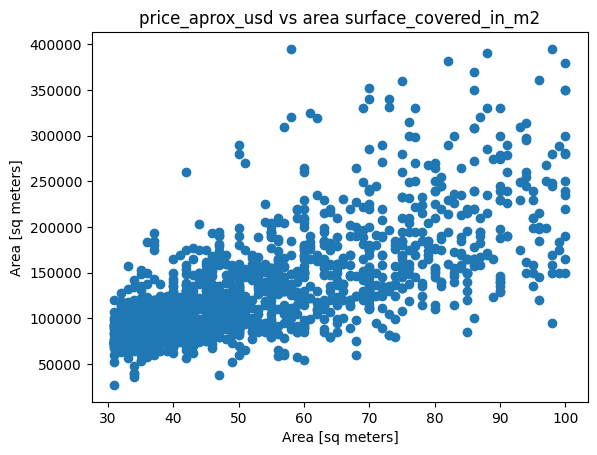

In [29]:
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Area [sq meters]")
plt.title("price_aprox_usd vs area surface_covered_in_m2")

## Data Splitting


In [31]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.head()

,surface_covered_in_m2
4,70.0
9,42.0
29,54.0
40,42.0
41,50.0


In [33]:
target = "price_aprox_usd"
y_train = df[target]
y_train.head()

4     129000.0
9      87000.0
29    118000.0
40     57000.0
41     90000.0
Name: price_aprox_usd, dtype: float64

## Train an Alogorithm/ Build Model


In [34]:
# build a model
y_mean = y_train.mean()
y_mean

np.float64(135527.83871928515)

In [35]:
#base line prediction
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[np.float64(135527.83871928515),
 np.float64(135527.83871928515),
 np.float64(135527.83871928515),
 np.float64(135527.83871928515),
 np.float64(135527.83871928515)]

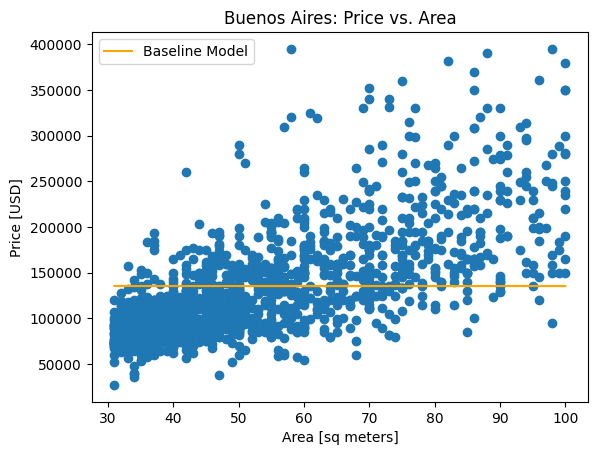

In [ ]:
# plot baseline model on a scatter plot
plt.plot(X_train.values, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [37]:
# evaluate baseline model
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


In [38]:
# instantiate your model
model = LinearRegression()

In [39]:
# train your model
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [40]:
# generate predictions
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [41]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26
